In [2]:
import os
os.environ['AEON_DEPRECATION_WARNING'] = 'False'
os.environ['KMP_WARNINGS'] = 'off'

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)

import fnmatch

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns
import scipy as sp
import scipy.fftpack as fp

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import stats

from aeon.transformations.collection.dictionary_based import PAA
import scipy.stats as stats

import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [16]:
path_queries = "queries/"

files_queries = {    
    "LenDB_queries.bin" : [256, np.float32],
    "SCEDC_queries.bin" : [256, np.float32],
    "Meier2019JGR_queries.bin" : [256, np.float32],
    "SIFT1b_queries.bin" : [256, np.float32],
    "OBS_queries.bin" : [256, np.float32],
    "bigANN_queries.bin" : [100, np.uint8],    
    "Iquique_queries.bin" : [256, np.float32],
    "astro_queries.bin": [256, np.float32],    
    "ETHZ_queries.bin" : [256, np.float32],
    "OBST2024_queries.bin" : [256, np.float32],
    "ISC_EHB_DepthPhases_queries.bin" : [256, np.float32],
    #"NEIC_queries.bin" : [256, np.float32],
    #"SALD_queries.bin" : [256, np.float32],    
    #"deep1b_queries.bin" : [96, np.float32],    
    #"PNW_queries.bin" : [256, np.float32],
}    

path = "../data_head/"

LenDB_queries.bin   	 False
SCEDC_queries.bin   	 False
Meier2019JGR_queries.bin   	 False
SIFT1b_queries.bin   	 False
OBS_queries.bin   	 False
bigANN_queries.bin   	 False
Iquique_queries.bin   	 False
astro_queries.bin   	 False
ETHZ_queries.bin   	 False
OBST2024_queries.bin   	 False
ISC_EHB_DepthPhases_queries.bin   	 False


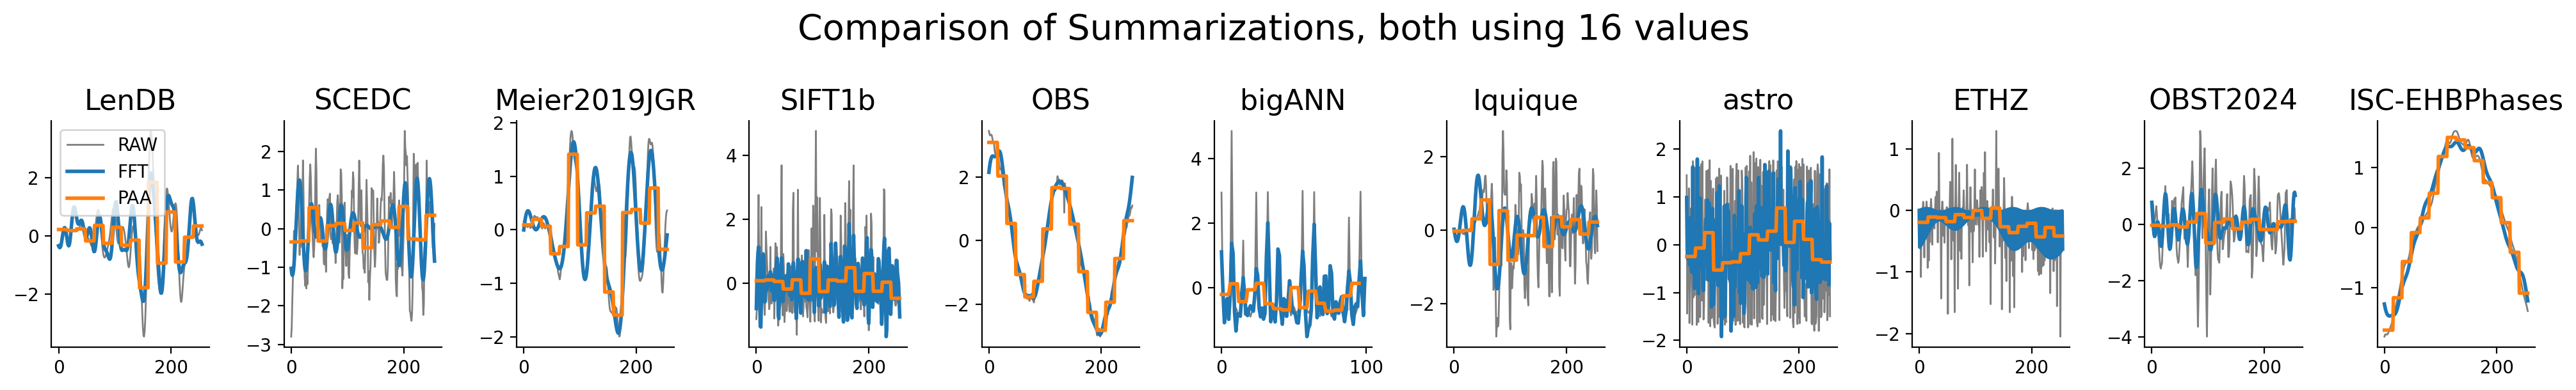

In [25]:
import warnings
warnings.filterwarnings("ignore", category=np.ComplexWarning)

fig, axes = plt.subplots(1, len(files_queries), figsize=(20, 3))

segments = 16
paa = PAA(n_segments=segments)
id = 4

for i, key in enumerate(files_queries):    
    file = path_queries + key
    length, data_type = files_queries[key]
    
    data = np.nan_to_num(np.fromfile(file, dtype=data_type))
    ## data = np.fromfile(file, dtype=np.float32)
    print(key, "  \t", np.isnan(data).any())

    data = (data[:len(data)-len(data)%length].reshape(-1, length)).T
    data = np.nan_to_num(sp.stats.zscore(data, axis = 1))

    paa_data = paa.fit_transform(data.T).squeeze(1)
    paa_data = paa_data[id,:]
    paa_data = np.repeat(paa_data, len(data)/len(paa_data))

    dft = fp.rfft(data.T)
    dft_variance = np.var(dft, axis=0)
    support = np.argsort(-dft_variance)[: segments + 1]
    support = np.sort(support)

    fft = fp.rfft(data[:,id])
    dft = np.zeros(fft.shape[0])
    dft[0] = fft[0]
    dft[support] = fft[support]

    fft_data = fp.irfft(dft)
    
    ax = axes.flatten()[i]
    sns.lineplot(data=data[:,id], ax = ax, lw=1, alpha=0.5, label="RAW", color="black")
    sns.lineplot(data=fft_data, ax = ax, lw=2, label="FFT")
    sns.lineplot(data=paa_data, ax = ax, lw=2, label="PAA")
    sns.despine()
    ax.set_title(key.replace("_queries", "").replace(".bin", "").replace("_", "-").replace("-Depth", ""), size=16)
    
    if i >= 1:
        ax.legend([],[], frameon=False)
        # plt.legend(False)

    # print(np.std(data), np.mean(data

# fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison of Summarizations, both using " + str(segments) + " values", y=1.0, size=20)
plt.tight_layout()

plt.savefig("images/data_fft_paa_3.pdf", bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

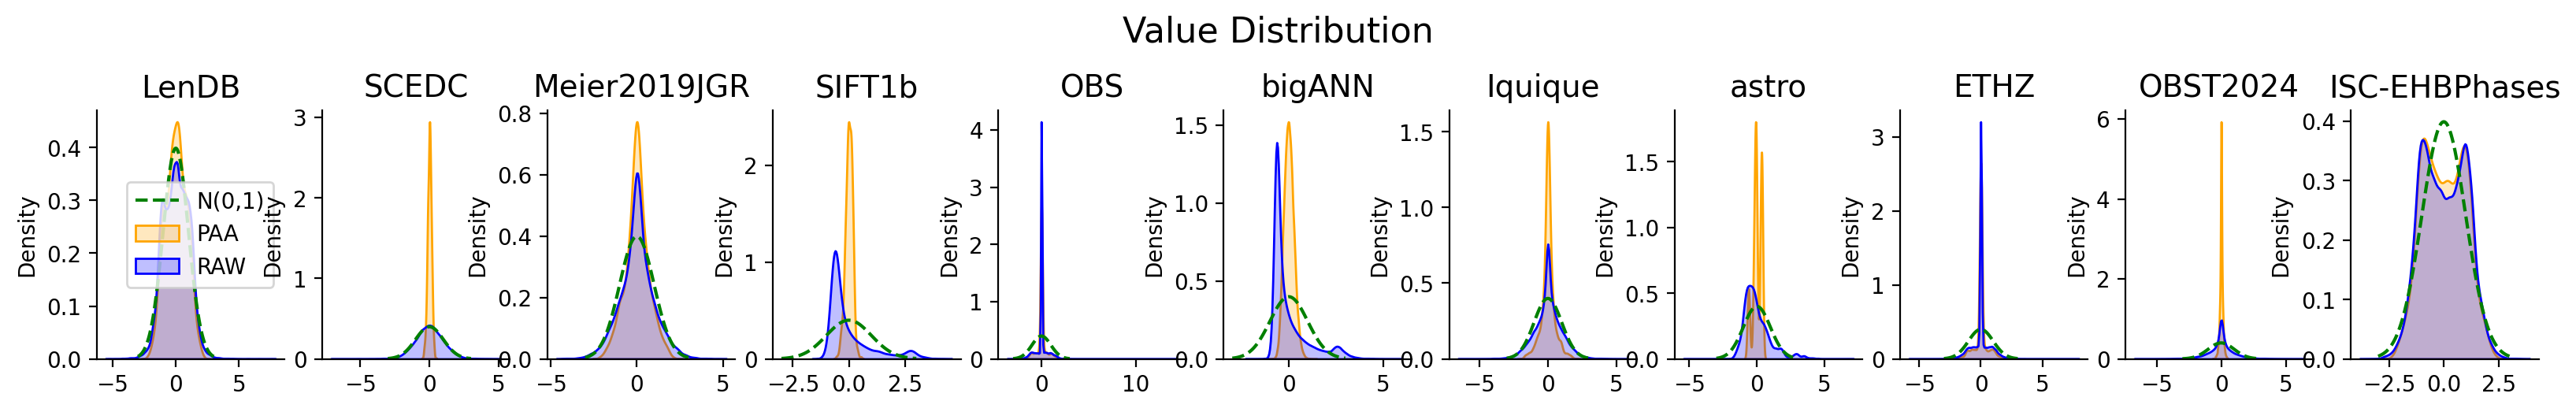

In [24]:
def plot_files(): 
    paa = PAA(n_segments=8)
    fig, axes = plt.subplots(1, len(files_queries), figsize=(20, 2))

    for i, key in enumerate(files_queries.keys()):
        file = path_queries + key
        # print(path_queries, file)
        
        length, data_type = files_queries[key]        
        data = np.nan_to_num(np.fromfile(file, dtype=data_type))
    
        data = (data[:len(data)-len(data)%length].reshape(-1, length))# [:100,:]
        data_normed = np.nan_to_num(sp.stats.zscore(data, axis=1))
                    
        x = np.linspace(0 - 3, 0 + 3, 100)
    
        ax = axes.flatten()[i]
        sns.lineplot(x=x, y=stats.norm.pdf(x, 0, 1), ax=ax, linestyle="--", color="green", label="N(0,1)")

        try : 
            paa_data = paa.fit_transform(data_normed)
            sns.kdeplot(data=paa_data.flatten(), ax = ax, label="PAA", color="orange", common_norm=False, fill=True)
        except:
            print("Error with PAA", key)
            # print (data[-1])
            print(key, "  \t", np.isnan(data).any())            
            print(key, "  \t", np.isfinite(data).any())
        
        sns.kdeplot(data=data_normed.flatten(), ax = ax, label="RAW", color="blue", common_norm=False, fill=True)
    
        ax.legend()
        ax.set_title(key.replace("_queries", "").replace(".bin", "").replace("_", "-").replace("-head", "").replace("-Depth", ""), size=14)    
        sns.despine()
        if i >=1:
            ax.legend([],[], frameon=False)

    fig.subplots_adjust(top=0.9)
    fig.suptitle("Value Distribution", y=1.20, size=16)
    # print(np.std(data), np.mean(data))
    

plt.tight_layout()
plot_files()
plt.savefig("images/distribution_data_3.pdf", bbox_inches='tight')
_ = plt.show()